In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification/soil_classification-2025/sample_submission.csv
/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv
/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv
/kaggle/input/soil-classification/soil_classification-2025/test/img_0f035b97.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_f13af256.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_15b41dbc.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_cfb4fc7a.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_683111fb.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c4bd7b3e.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_4ccce0f8.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_86faa98d.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c448342c.jpg
/kaggle/input/soil-classification/soil_cla

# **Title: Soil Image Classification Challenge - IIT Ropar (Annam.ai)**
**Author:** Deveshu Pathak

**Problem Statement:**
**Classify soil images into one of four categories:**

* Alluvial soil
* Black soil
* Clay soil
* Red soil


**Evaluation Metric:** Minimum F1-score across all 4 classes


# Importing Required Libraries

This cell imports libraries needed for the soil classification project:

- **os**: Handles file paths and directory operations.
- **pandas as pd**: Manages datasets like CSV files.
- **numpy as np**: Supports numerical operations on arrays.
- **matplotlib.pyplot as plt**: Creates visualizations like plots.
- **seaborn as sns**: Enhances visualizations, e.g., bar plots.
- **sklearn.preprocessing.LabelEncoder**: Converts text labels to numbers.
- **sklearn.metrics.f1_score, classification_report**: Evaluates model performance.
- **sklearn.model_selection.train_test_split**: Splits data into training and validation sets.
- **tqdm**: Shows progress bars for loops.
- **torch, torch.nn, torch.utils.data**: PyTorch tools for building and training neural networks.
- **torchvision.transforms**: Applies image preprocessing.
- **PIL.Image**: Loads and processes images.
- **timm**: Provides pre-trained computer vision models.
- **random**: Adds randomness, e.g., for data shuffling.

This sets up the tools for data processing, model training, and evaluation.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report,confusion_matrix, accuracy_score, top_k_accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import random

# Loading Data and Setting File Paths

- **BASE_PATH**: Defines the root directory for the dataset (`/kaggle/input/soil-classification/soil_classification-2025`).
- **TRAIN_DIR**: Points to the training images folder.
- **TEST_DIR**: Points to the test images folder.
- **train_labels**: Loads `train_labels.csv`, containing image IDs and their soil type labels.
- **test_ids**: Loads `test_ids.csv`, listing image IDs for the test set.
- **sample_submission**: Loads `sample_submission.csv`, providing the format for competition submissions.

This organizes the dataset's file paths and loads metadata for training and testing.

In [3]:
BASE_PATH = "/kaggle/input/soil-classification/soil_classification-2025"
TRAIN_DIR = os.path.join(BASE_PATH, "train")
TEST_DIR = os.path.join(BASE_PATH, "test")
train_labels = pd.read_csv(os.path.join(BASE_PATH, "train_labels.csv"))
test_ids = pd.read_csv(os.path.join(BASE_PATH, "test_ids.csv"))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, "sample_submission.csv"))

# EDA - Sample Images Per Class
### Soil Type Distribution
- Counts images per soil type in `train_labels` and plots a bar chart using `seaborn`.
- Plot size is 8x4 inches, with x-axis labels rotated 45 degrees.
- Title: "Soil Type Distribution".
- Shows the balance of soil types in the dataset.

### Sample Images
- Displays one image per soil type in a 1x4 grid (15x5 inches).
- Loads images from `TRAIN_DIR` using the first image ID for each soil type.
- Each subplot shows an image, titled with the soil type, with axes hidden.
- Main title: "Sample Images by Soil Type".

This visualizes the dataset's soil type distribution and example images.

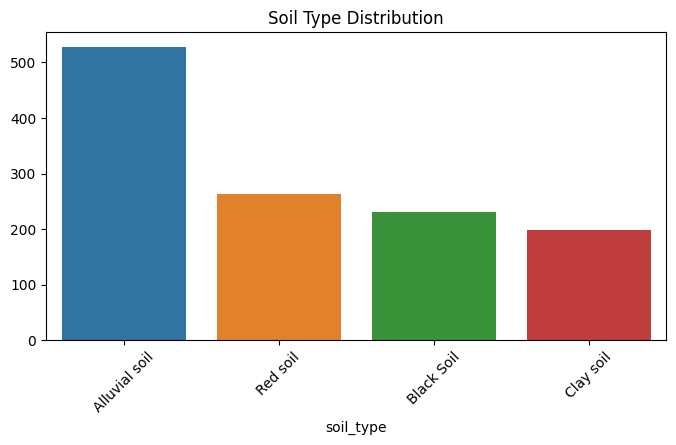

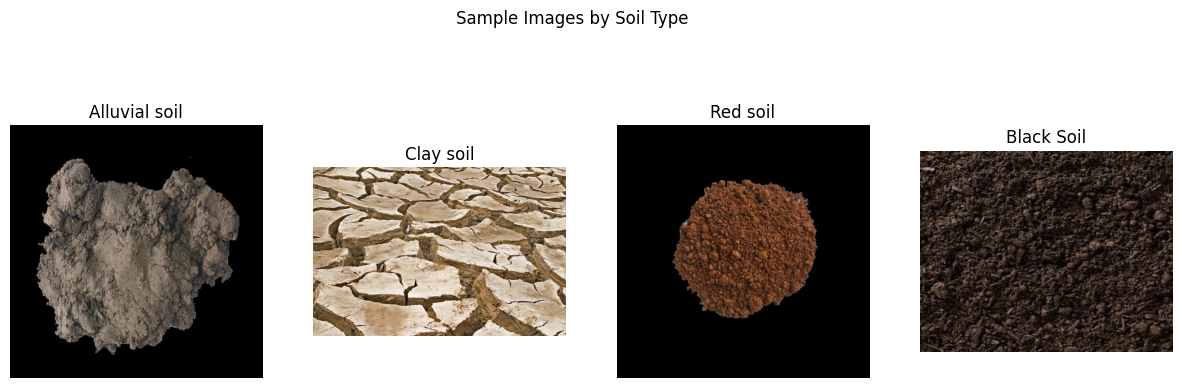

In [4]:
label_counts = train_labels["soil_type"].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Soil Type Distribution")
plt.xticks(rotation=45)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(15,5))
soil_types = train_labels["soil_type"].unique()
for idx, soil in enumerate(soil_types):
    sample_img_id = train_labels[train_labels.soil_type == soil].image_id.values[0]
    img = Image.open(os.path.join(TRAIN_DIR, sample_img_id))
    axs[idx].imshow(img)
    axs[idx].set_title(soil)
    axs[idx].axis("off")
plt.suptitle("Sample Images by Soil Type")
plt.show()

# Defining the Soil Dataset Class

- Creates a custom `SoilDataset` class to load images and labels for training, validation, or testing.
- **Inputs**:
  - `dataframe`: Contains image IDs and labels (or IDs for test data).
  - `img_dir`: Directory with images.
  - `transform`: Optional image transformations (e.g., resizing, augmentation).
  - `is_test`: Flag to indicate test mode (returns image IDs instead of labels).
- **Methods**:
  - `__len__`: Returns the dataset size.
  - `__getitem__`: Loads an RGB image by ID, applies transformations if specified, and returns the image with its label (or ID for test data).

This prepares images and labels for model training or testing.

In [5]:
class SoilDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name

        label = self.df.iloc[idx]['label']
        return image, label

# Label Encoding and Image Transformation

- **Label Encoding**:
  - Uses `LabelEncoder` to convert `soil_type` text labels in `train_labels` to numerical values, stored in a new `label` column.
  - Saves unique soil type names in `class_names` for later use.

- **Image Transformation**:
  - Defines a `transform` pipeline using `torchvision.transforms.Compose`:
    - Resizes images to 224x224 pixels.
    - Converts images to PyTorch tensors.
    - Normalizes pixel values to a range centered at 0.5 for each RGB channel.

This prepares numerical labels and standardizes images for model training.

In [6]:
le = LabelEncoder()
train_labels["label"] = le.fit_transform(train_labels["soil_type"])
class_names = le.classes_

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Splitting Data and Creating Data Loaders

- **Data Splitting**:
  - Splits `train_labels` into training (80%) and validation (20%) sets using `train_test_split`.
  - Stratifies by `label` to maintain soil type distribution.
  - Uses random seed 42 for reproducibility.

- **Datasets**:
  - `train_dataset`: Training data with `transform` applied.
  - `val_dataset`: Validation data with `transform` applied.
  - `test_dataset`: Test data with `transform` applied, set to `is_test=True` to return image IDs.

- **Data Loaders**:
  - `train_loader`: Loads training data in batches of 32, with shuffling.
  - `val_loader`: Loads validation data in batches of 32, without shuffling.
  - `test_loader`: Loads test data in batches of 32, without shuffling.

This organizes data into batches for model training, validation, and testing.

In [7]:
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels["label"], random_state=42)

train_dataset = SoilDataset(train_df, TRAIN_DIR, transform=transform)
val_dataset = SoilDataset(val_df, TRAIN_DIR, transform=transform)
test_dataset = SoilDataset(test_ids, TEST_DIR, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Setting Up the Model

- Initializes an EfficientNet-B0 model using `timm.create_model`, pre-trained on ImageNet, with 4 output classes for soil types.
- Selects GPU (`cuda`) if available, otherwise uses CPU.
- Moves the model to the chosen device for training or inference.

This prepares a pre-trained model for soil classification.

In [8]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# Training the Model

### Loss and Optimizer
- Uses `CrossEntropyLoss` as the loss function for multi-class classification.
- Sets up the Adam optimizer with a learning rate of 0.0001 for model parameters.

### Training Function
- Defines `train_model` to train and validate the model for 10 epochs.
- **Training**:
  - Sets model to training mode, processes `train_loader` batches, and moves data to device (GPU/CPU).
  - Computes loss, updates weights via backpropagation, and tracks average training loss.
- **Validation**:
  - Sets model to evaluation mode, processes `val_loader` batches without gradients.
  - Calculates validation loss and predictions, then computes the minimum F1 score across classes.
- Prints training loss, validation loss, and minimum F1 score per epoch.
- Returns lists of training losses, validation losses, and minimum F1 scores.

### Execution
- Trains the model for 10 epochs using `train_loader` and `val_loader`.

This trains the EfficientNet-B0 model and evaluates its performance.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, epochs=5):
    best_score = 0
    train_losses, val_losses, f1_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        preds, true = [], []
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds += torch.argmax(outputs, 1).cpu().numpy().tolist()
                true += labels.cpu().numpy().tolist()

        f1 = f1_score(true, preds, average=None)
        f1_scores.append(min(f1))
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Min F1: {min(f1):.4f}")

    return train_losses, val_losses, f1_scores, true, preds


train_losses, val_losses, min_f1_scores, y_true, y_pred = train_model(model, train_loader, val_loader, epochs=10)

100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Epoch 1: Train Loss: 1.5198, Val Loss: 0.3346, Min F1: 0.8846


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Epoch 2: Train Loss: 0.1532, Val Loss: 0.1981, Min F1: 0.9375


100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


Epoch 3: Train Loss: 0.0699, Val Loss: 0.2325, Min F1: 0.9512


100%|██████████| 31/31 [00:11<00:00,  2.61it/s]


Epoch 4: Train Loss: 0.0464, Val Loss: 0.2681, Min F1: 0.9574


100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Epoch 5: Train Loss: 0.0308, Val Loss: 0.2571, Min F1: 0.9474


100%|██████████| 31/31 [00:11<00:00,  2.75it/s]


Epoch 6: Train Loss: 0.0233, Val Loss: 0.2651, Min F1: 0.9375


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Epoch 7: Train Loss: 0.0155, Val Loss: 0.2337, Min F1: 0.9474


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Epoch 8: Train Loss: 0.0162, Val Loss: 0.2159, Min F1: 0.9375


100%|██████████| 31/31 [00:12<00:00,  2.53it/s]


Epoch 9: Train Loss: 0.0098, Val Loss: 0.2467, Min F1: 0.9684


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Epoch 10: Train Loss: 0.0105, Val Loss: 0.2279, Min F1: 0.9375


# Evaluating Model Performance

- **Classification Report**:
  - Converts `y_true` and `y_pred` to NumPy arrays (assumed to be ground truth and predicted labels).
  - Prints a classification report using `sklearn.metrics.classification_report`, showing precision, recall, and F1-score for each soil type in `class_names`.

- **F1-Score**:
  - Computes per-class F1-scores using `f1_score` with `average=None`.
  - Prints the minimum F1-score across classes as the competition metric.

- **Accuracy**:
  - Calculates and prints the accuracy using `sklearn.metrics.accuracy_score`.

- **Confusion Matrix**:
  - Generates a confusion matrix using `sklearn.metrics.confusion_matrix`.
  - Plots a heatmap with `seaborn` (8x6 inches), annotated with counts, using `class_names` for labels and a "Blues" colormap.
  - Labels axes as "Predicted" and "True" with the title "Confusion Matrix".

- **Top-2 Accuracy**:
  - Sets the model to evaluation mode and processes `val_loader` batches without gradients.
  - Collects model output scores and true labels from the validation set.
  - Computes top-2 accuracy using `sklearn.metrics.top_k_accuracy_score`, evaluating if the true label is among the top 2 predicted classes.
  - Prints the top-2 accuracy.

This evaluates the model’s performance on the validation set using multiple metrics and visualizes classification results.

 Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.99      0.94      0.97       106
   Black Soil       0.90      0.98      0.94        46
    Clay soil       0.95      0.97      0.96        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.97       245
    macro avg       0.96      0.97      0.97       245
 weighted avg       0.97      0.97      0.97       245


 Minimum F1-score (Competition Metric): 0.9375
Accuracy: 0.9673


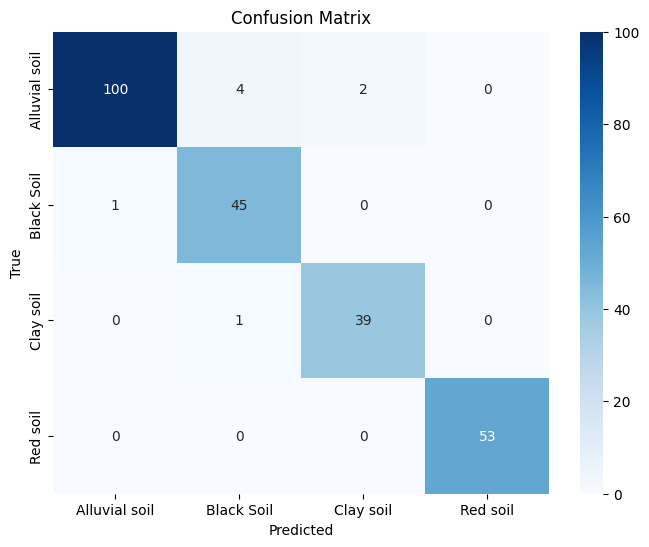

 Top-2 Accuracy: 0.9918


In [10]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

f1s = f1_score(y_true, y_pred, average=None)
min_f1 = f1s.min()
print(f"\n Minimum F1-score (Competition Metric): {min_f1:.4f}")

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

model.eval()
top2_preds_scores = []
top2_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)  # shape: (batch_size, num_classes)
        top2_preds_scores.extend(outputs.cpu().numpy())
        top2_true.extend(labels.numpy())

top2_preds_scores = np.array(top2_preds_scores)
top2_true = np.array(top2_true)

top2_acc = top_k_accuracy_score(top2_true, top2_preds_scores, k=2)
print(f" Top-2 Accuracy: {top2_acc:.4f}")


# Plotting Model Performance

- Creates a figure with two subplots (12x4 inches) to visualize training results.
- **Left Subplot**: Shows training and validation losses (`train_losses`, `val_losses`) over epochs.
  - Title: "Loss over Epochs".
  - Includes a legend to differentiate curves.
- **Right Subplot**: Plots the minimum F1 score (`min_f1_scores`) across classes over epochs.
  - Title: "Min F1-score over Epochs".
  - Includes a legend.
- Displays the plots to show trends in model performance.

This visualizes how the model’s loss and F1 score evolve during training.

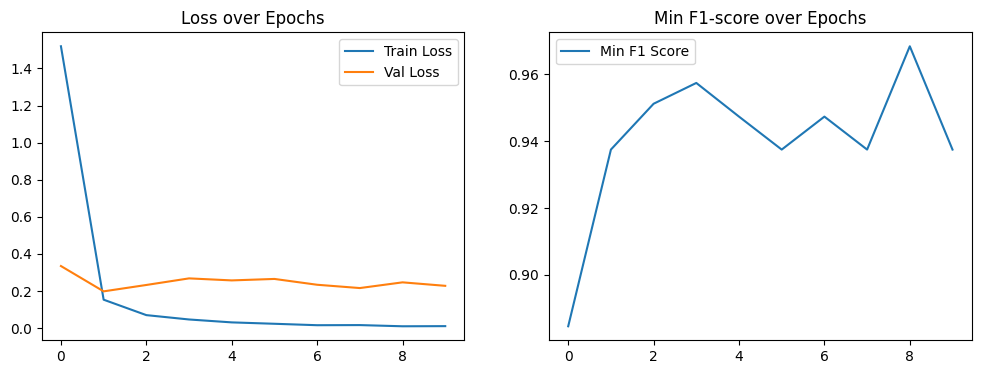

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(min_f1_scores, label='Min F1 Score')
plt.title('Min F1-score over Epochs')
plt.legend()
plt.show()

# Generating Test Predictions

- Sets the model to evaluation mode to disable training-specific operations.
- Initializes lists for storing predictions and image IDs.
- **Prediction Loop**:
  - Processes batches from `test_loader`, moving images to the device (GPU/CPU).
  - Computes model outputs and selects the class with the highest score using `argmax`.
  - Converts numerical predictions back to soil type names using `LabelEncoder.inverse_transform`.
- Stores predicted soil types in `predictions` and image IDs in `image_ids`.

This generates predictions for the test set using the trained model.

In [12]:
model.eval()
predictions = []
image_ids = []
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        preds = le.inverse_transform(preds)
        predictions.extend(preds)
        image_ids.extend(img_names)

# Creating and Saving Submission File

- Creates a pandas DataFrame `submission` with:
  - `image_id`: Test set image IDs.
  - `soil_type`: Predicted soil types.
- Sorts the DataFrame by `image_id` to match the required submission format.
- Saves the DataFrame to `submission.csv` without an index column.
- Displays the first few rows to verify the submission.

This prepares the final predictions for the Kaggle competition.

In [13]:
submission = pd.DataFrame({
    "image_id": image_ids,
    "soil_type": predictions
})
submission = submission.sort_values("image_id")
submission.to_csv("submission.csv", index=False)
submission.head()

,image_id,soil_type
52,img_000f12db.jpg,Alluvial soil
221,img_00a44450.jpg,Red soil
185,img_00af6b3b.jpg,Red soil
188,img_01a3f913.jpg,Red soil
203,img_01e540fc.jpg,Red soil
